<a href="https://colab.research.google.com/github/hyunicecream/Natural-Language-Processing-NLP-/blob/main/seq2seq(train_attention).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
"""7-4.seq2seq(train_attention).ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/196fxfudMV3Ylr3jfUrnhRYwOYFqAvRdQ
"""

# Commented out IPython magic to ensure Python compatibility.
# 작업 디렉토리를 변경한다.
# %cd '/content/drive/My Drive/Colab Notebooks'

# Seq2Seq-Attention 모델를 이용한 ChatBot : 학습 모듈
#
# 관련 논문 : Kyunghyun Cho, et. al., 2014,
#             Learning Phrase Representations using RNN Encoder–Decoder 
#             for Statistical Machine Translation
#
# 코드 구현 : 2020.07.30, 조성현 (blog.naver.com/chunjein)
# copyright: SNS 등에 공개할 때는 출처에 저작자를 명시해 주시기 바랍니다.
# ----------------------------------------------------------------------
from tensorflow.keras.layers import Input, LSTM, Dense, Dot, Concatenate
from tensorflow.keras.layers import Embedding, TimeDistributed, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import pickle

# 단어 목록 dict를 읽어온다.
with open('/content/drive/MyDrive/머신러닝/seq2seq/chatbot_voc.pkl', 'rb') as f:
    word2idx,  idx2word = pickle.load(f)
    
# 학습 데이터 : 인코딩, 디코딩 입력, 디코딩 출력을 읽어온다.
with open('/content/drive/MyDrive/머신러닝/seq2seq/chatbot_train.pkl', 'rb') as f:
    trainXE, trainXD, trainYD, _, _ = pickle.load(f)

In [ ]:
VOCAB_SIZE = len(idx2word)
EMB_SIZE = 128
LSTM_HIDDEN = 128
MODEL_PATH = '/content/drive/MyDrive/머신러닝/seq2seq/chatbot_attention.h5'
LOAD_MODEL = True

# Encoder 출력과 decoder 출력으로 attention value를 생성하고,
# decoder 출력 + attention value (concatenate)를 리턴한다.
# x : encoder 출력, y : decoder 출력
# LSTM time step = 4, EMB_SIZE = 3 이라면 각 텐서의 dimension은
# 아래 주석과 같다.
def Attention(x, y):
    # step-1:
    # decoder의 매 시점마다 encoder의 전체 시점과 dot-product을 수행한다.
    score = Dot(axes=(2, 2))([y, x])                   # (1, 4, 4)
    
    # step-2:
    # dot-product 결과를 확률분포로 만든다 (softmax)
    # 이것이 attention score이다.
    dist = Activation('softmax')(score)                # (1, 4, 4)

    # step-3:
    # Attention value를 계산한다.
    attention = Dot(axes=(2, 1))([dist, x])

    # step-4:
    # decoder 출력과 attention을 concatenate 한다.
    return Concatenate()([y, attention])    # (1, 4, 6)

In [ ]:
# 워드 임베딩 레이어. Encoder와 decoder에서 공동으로 사용한다.
K.clear_session()
wordEmbedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMB_SIZE)

# Encoder
# -------
# many-to-many로 구성한다. Attention value를 계산하기 위해 중간 출력이 필요하고
# (return_sequences=True), decoder로 전달할 h와 c도 필요하다 (return_state = True)
encoderX = Input(batch_shape=(None, trainXE.shape[1]))
encEMB = wordEmbedding(encoderX)
encLSTM1 = LSTM(LSTM_HIDDEN, return_sequences=True, return_state = True)
encLSTM2 = LSTM(LSTM_HIDDEN, return_sequences=True, return_state = True)
ey1, eh1, ec1 = encLSTM1(encEMB)    # LSTM 1층 
ey2, eh2, ec2 = encLSTM2(ey1)       # LSTM 2층

# Decoder
# -------
# many-to-many로 구성한다. target을 학습하기 위해서는 중간 출력이 필요하다.
# 그리고 초기 h와 c는 encoder에서 출력한 값을 사용한다 (initial_state)
# 최종 출력은 vocabulary의 인덱스인 one-hot 인코더이다.
decoderX = Input(batch_shape=(None, trainXD.shape[1]))
decEMB = wordEmbedding(decoderX)
decLSTM1 = LSTM(LSTM_HIDDEN, return_sequences=True, return_state=True)
decLSTM2 = LSTM(LSTM_HIDDEN, return_sequences=True, return_state=True)
dy1, _, _ = decLSTM1(decEMB, initial_state = [eh1, ec1])
dy2, _, _ = decLSTM2(dy1, initial_state = [eh2, ec2])
att_dy2 = Attention(ey2, dy2)
decOutput = TimeDistributed(Dense(VOCAB_SIZE, activation='softmax'))
outputY = decOutput(att_dy2)

# Model
# -----
model = Model([encoderX, decoderX], outputY)
model.compile(optimizer=optimizers.Adam(learning_rate=0.0005), 
              loss='sparse_categorical_crossentropy')
model.summary()
if LOAD_MODEL:
    model.load_weights(MODEL_PATH)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 128)      1152000     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 15, 128), (N 131584      embedding[0][0]              

In [ ]:
# 학습 (teacher forcing)
hist = model.fit([trainXE, trainXD], trainYD, batch_size = 512, epochs=300, shuffle=True)

Epoch 1/300
21/21 [==============================] - 6s 67ms/step - loss: 0.3127
Epoch 2/300
21/21 [==============================] - 1s 67ms/step - loss: 0.2634
Epoch 3/300
21/21 [==============================] - 1s 66ms/step - loss: 0.2442
Epoch 4/300
21/21 [==============================] - 1s 66ms/step - loss: 0.2364
Epoch 5/300
21/21 [==============================] - 1s 67ms/step - loss: 0.2318
Epoch 6/300
21/21 [==============================] - 1s 68ms/step - loss: 0.2291
Epoch 7/300
21/21 [==============================] - 1s 68ms/step - loss: 0.2273
Epoch 8/300
21/21 [==============================] - 1s 67ms/step - loss: 0.2260
Epoch 9/300
21/21 [==============================] - 1s 67ms/step - loss: 0.2265
Epoch 10/300
21/21 [==============================] - 1s 67ms/step - loss: 0.2262
Epoch 11/300
21/21 [==============================] - 1s 66ms/step - loss: 0.2247
Epoch 12/300
21/21 [==============================] - 1s 66ms/step - loss: 0.2234
Epoch 13/300
21/21 [=====

In [ ]:
# 학습 결과를 저장한다
model.save_weights(MODEL_PATH)

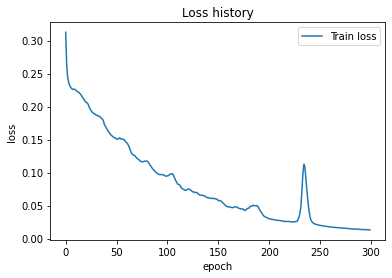

In [ ]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()